### < 모델 생성 후 고려해볼 것들>
1. 모델을 여러가지 사용해보기 ex) 앙상블, XGBoost, Light GBM, LSTM
2. 이상치를 중앙값으로 할지, 최대치로 할지
3. 시계열 데이터를 어떻게 처리할지 ex) 4분기, 2분기 등
4. 판매량, 판매 가격의 데이터 쏠림을 전처리 할지 말지
-> 팀당 하루에 5번 제출 가능

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from os.path import join

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 1. 데이터 불러오기

In [2]:
# data_dir = os.getenv('HOME') + '/kaggle/predict_future_sales/data'
data_dir = os.getenv('HOME')+'/aiffel/hac1/'
items_path = os.path.join(data_dir, 'items.csv')
item_category_path = os.path.join(data_dir, 'item_categories.csv')
shops_path = os.path.join(data_dir, 'shops.csv')
train_path = os.path.join(data_dir, 'sales_train.csv')
test_path = os.path.join(data_dir, 'test.csv')

In [3]:
items = pd.read_csv(items_path)
categories = pd.read_csv(item_category_path)
shops = pd.read_csv(shops_path)
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

<br><br><br>

# 2. 데이터 분석

* 파일 설명  


sales_train.csv- 훈련 세트. 2013 년 1 월부터 2015 년 10 월까지의 일일 기록 데이터.  
test.csv- 테스트 세트. 이러한 상점과 제품의 2015 년 11 월 매출을 예측해야합니다.  
sample_submission.csv- 올바른 형식의 샘플 제출 파일.  
items.csv- 항목 / 제품에 대한 추가 정보.  
item_categories.csv- 항목 카테고리에 대한 추가 정보입니다.  
shops.csv- 상점에 대한 추가 정보.  


* 데이터 필드


ID- 테스트 세트 내에서 (Shop, Item) 튜플을 나타내는 Id  
shop_id- 상점의 고유 식별자  
item_id- 상품의 고유 식별자  
item_category_id- 항목 카테고리의 고유 식별자  
item_cnt_day- 판매 된 제품 수입니다. 이 측정 값의 월별 금액을 예측하고 있습니다.  
item_price- 상품의 현재 가격  
date -dd / mm / yyyy 형식의 날짜  
date_block_num- 편의를 위해 사용되는 연속 된 월 번호. 2013 년 1 월은 0, 2013 년 2 월은 1, ..., 2015 년 10 월은 33입니다.  
item_name- 항목 이름  
shop_name- 상점 이름  
item_category_name- 항목 카테고리 이름  

In [4]:
data = pd.read_csv(train_path)
sub = pd.read_csv(test_path)
print('train data dim : {}'.format(data.shape))
print('test data dim : {}'.format(sub.shape))

train data dim : (2935849, 6)
test data dim : (214200, 3)


In [5]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [7]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [8]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [9]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [11]:
train['shop_id'].value_counts()

31    235636
25    186104
54    143480
28    142234
57    117428
42    109253
27    105366
6      82663
58     71441
56     69573
46     66321
50     65173
19     63911
15     59511
35     58445
21     58133
7      58076
47     56695
26     53910
18     53227
24     53032
53     52921
16     52734
30     50860
29     49225
38     46013
22     45434
51     44433
52     43502
59     42108
41     41967
37     39638
44     39530
43     39282
4      38242
5      38179
14     36979
45     35891
55     34769
12     34694
2      25991
3      25532
17     22950
48     21612
10     21397
13     17824
49     15849
39     13440
0       9857
32      7947
23      6963
34      5752
1       5678
33      5027
40      4257
9       3751
8       3412
20      1792
11       499
36       306
Name: shop_id, dtype: int64

In [12]:
test['shop_id'].value_counts()

59    5100
16    5100
28    5100
26    5100
25    5100
24    5100
22    5100
21    5100
19    5100
18    5100
15    5100
58    5100
14    5100
12    5100
10    5100
7     5100
6     5100
5     5100
4     5100
3     5100
31    5100
34    5100
35    5100
36    5100
57    5100
56    5100
55    5100
53    5100
52    5100
50    5100
49    5100
48    5100
47    5100
46    5100
45    5100
44    5100
42    5100
41    5100
39    5100
38    5100
37    5100
2     5100
Name: shop_id, dtype: int64

trainset의 가게분포는 불규칙하지만 test셋의 분포는 일정함

## 3. Feature Engineering

#### 3.1 데이터 결측치 확인

In [13]:
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

#### 3.2 중복 제거

In [14]:
sum(train.duplicated()), sum(test.duplicated())

(6, 0)

In [15]:
train[train.duplicated() == True]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,05.01.2013,0,54,20130,149.0,1.0
1435367,23.02.2014,13,50,3423,999.0,1.0
1496766,23.03.2014,14,21,3423,999.0,1.0
1671873,01.05.2014,16,50,3423,999.0,1.0
1866340,12.07.2014,18,25,3423,999.0,1.0
2198566,31.12.2014,23,42,21619,499.0,1.0


In [16]:
train.drop_duplicates(inplace=True)

In [17]:
#중복 재확인
sum(train.duplicated())

0

#### 3.3 이상치 제거(진오님)

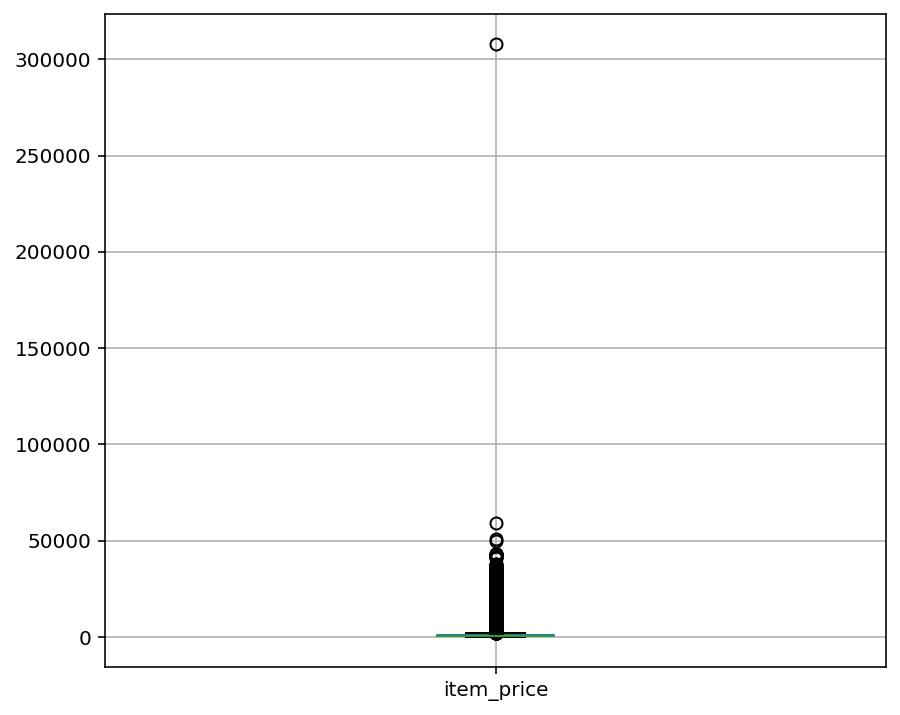

In [23]:
plt.figure(figsize=(7,6))
train.boxplot(column=['item_price'])
plt.show()

In [24]:
# 이상치 갯수
train[train['item_price']>=50000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
885138,17.09.2013,8,12,11365,59200.0,1.0
1163158,13.12.2013,11,12,6066,307980.0,1.0
1488135,20.03.2014,14,25,13199,50999.0,1.0


In [25]:
# 가격 10만이상 제거

train_1 = train[train['item_price']<=100000]
train_1

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


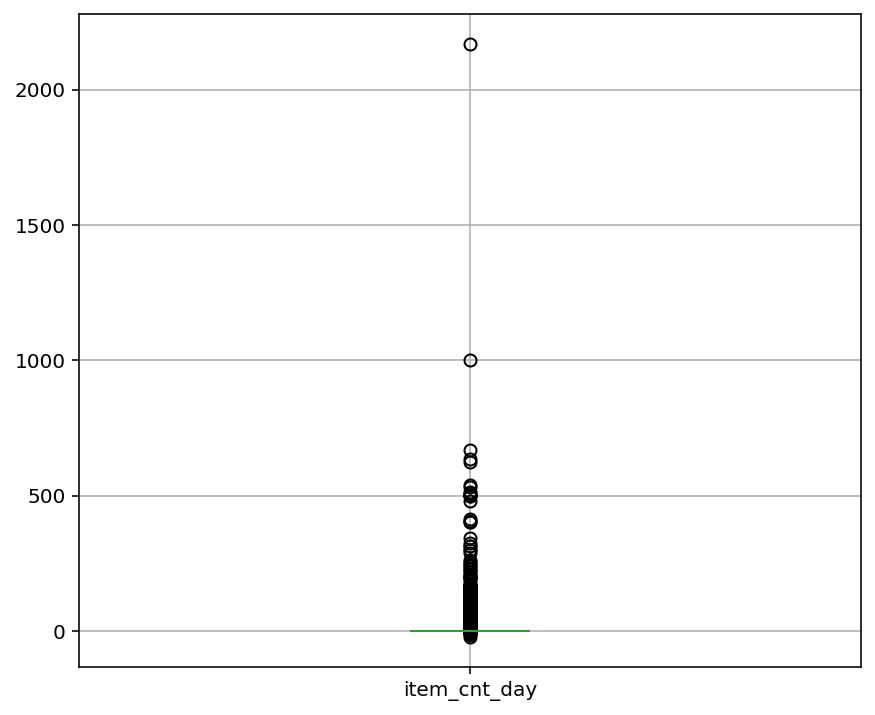

In [26]:
plt.figure(figsize=(7,6))
train_1.boxplot(column=['item_cnt_day'])
plt.show()

In [27]:
# 판매량 500이상 제거

train[train['item_cnt_day']>=500]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1573253,22.04.2014,15,27,8057,1200.000000,502.0
1708207,28.06.2014,17,25,20949,5.000000,501.0
2048518,02.10.2014,21,12,9242,1500.000000,512.0
2067669,09.10.2014,21,55,19437,899.000000,508.0
2257299,19.12.2014,23,12,20949,4.000000,500.0
2326930,15.01.2015,24,12,20949,4.000000,1000.0
2608040,14.04.2015,27,12,3731,1904.548077,624.0
2626181,19.05.2015,28,12,11373,155.192950,539.0
2851073,29.09.2015,32,55,9249,1500.000000,533.0
2851091,30.09.2015,32,55,9249,1702.825746,637.0


In [29]:
train_1 = train_1[train_1['item_cnt_day']<=500]
train_1

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [30]:
# 값 정렬했는데 마이너스 발견 >> 제거
train_1.sort_values('item_price', axis=0, ascending=False)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
885138,17.09.2013,8,12,11365,59200.0000,1.0
1488135,20.03.2014,14,25,13199,50999.0000,1.0
2327159,29.01.2015,24,12,7241,49782.0000,1.0
2931380,20.10.2015,33,22,13403,42990.0000,1.0
2917760,20.10.2015,33,3,13403,42990.0000,1.0
...,...,...,...,...,...,...
673155,31.07.2013,6,6,11872,0.0900,1.0
611400,08.06.2013,5,58,20146,0.0875,4.0
608763,08.06.2013,5,58,11865,0.0700,1.0
579766,11.06.2013,5,6,11864,0.0700,1.0


In [31]:
train_1 = train_1[train_1['item_price'] != -1.0000]

In [32]:
# 최종 결과

train_1

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


#### 3.4 아이템 대분류 만들기(은지님 추가)

#### 3.5 지역별 가게 대분류 만들기

In [18]:
shop_data_path = join(data_dir, 'shops.csv')
shops = pd.read_csv(shop_data_path)
pd.DataFrame(shops.shop_name.values.reshape(-1, 4))

,0,1,2,3
0,"!Якутск Орджоникидзе, 56 фран","!Якутск ТЦ ""Центральный"" фран","Адыгея ТЦ ""Мега""","Балашиха ТРК ""Октябрь-Киномир"""
1,"Волжский ТЦ ""Волга Молл""","Вологда ТРЦ ""Мармелад""","Воронеж (Плехановская, 13)","Воронеж ТРЦ ""Максимир"""
2,"Воронеж ТРЦ Сити-Парк ""Град""",Выездная Торговля,Жуковский ул. Чкалова 39м?,Жуковский ул. Чкалова 39м²
3,Интернет-магазин ЧС,"Казань ТЦ ""Бехетле""","Казань ТЦ ""ПаркХаус"" II","Калуга ТРЦ ""XXI век"""
4,"Коломна ТЦ ""Рио""","Красноярск ТЦ ""Взлетка Плаза""","Красноярск ТЦ ""Июнь""","Курск ТЦ ""Пушкинский"""
5,"Москва ""Распродажа""","Москва МТРЦ ""Афи Молл""",Москва Магазин С21,"Москва ТК ""Буденовский"" (пав.А2)"
6,"Москва ТК ""Буденовский"" (пав.К7)","Москва ТРК ""Атриум""","Москва ТЦ ""Ареал"" (Беляево)","Москва ТЦ ""МЕГА Белая Дача II"""
7,"Москва ТЦ ""МЕГА Теплый Стан"" II","Москва ТЦ ""Новый век"" (Новокосино)","Москва ТЦ ""Перловский""","Москва ТЦ ""Семеновский"""
8,"Москва ТЦ ""Серебряный Дом""","Мытищи ТРК ""XL-3""","Н.Новгород ТРЦ ""РИО""","Н.Новгород ТРЦ ""Фантастика"""
9,"Новосибирск ТРЦ ""Галерея Новосибирск""","Новосибирск ТЦ ""Мега""","Омск ТЦ ""Мега""","РостовНаДону ТРК ""Мегацентр Горизонт"""


In [19]:
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops.head(10)

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский
5,"Вологда ТРЦ ""Мармелад""",5,Вологда
6,"Воронеж (Плехановская, 13)",6,Воронеж
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж
9,Выездная Торговля,9,Выездная


In [20]:
# 문자 데이터를 모두 수치 데이터로 Encoding
shops.city.value_counts()

Москва              13
Якутск               4
РостовНаДону         3
Тюмень               3
Воронеж              3
Самара               2
Новосибирск          2
Жуковский            2
СПб                  2
Уфа                  2
Казань               2
Н.Новгород           2
Красноярск           2
Мытищи               1
Калуга               1
Выездная             1
Вологда              1
Балашиха             1
Волжский             1
Сергиев              1
Омск                 1
Чехов                1
Адыгея               1
Томск                1
Химки                1
Курск                1
Цифровой             1
Интернет-магазин     1
Ярославль            1
Сургут               1
Коломна              1
Name: city, dtype: int64

In [21]:
from sklearn.preprocessing import LabelEncoder
city_encoder = LabelEncoder()
shops['city_code'] = city_encoder.fit_transform(shops['city'])
shops = shops[['shop_id', 'city_code']]
shops.head()

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


#### train 데이터에 city_code, item_code 추가하기

In [22]:
merged_df = pd.merge(train, shops, on="shop_id")
merged_df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,city_code
0,02.01.2013,0,59,22154,999.0,1.0,30
1,10.01.2013,0,59,22151,399.0,1.0,30
2,04.01.2013,0,59,5603,699.0,1.0,30
3,19.01.2013,0,59,5587,199.0,2.0,30
4,31.01.2013,0,59,5613,5571.0,1.0,30
...,...,...,...,...,...,...,...
2935838,30.10.2015,33,36,20231,169.0,1.0,16
2935839,18.10.2015,33,36,20334,1949.0,1.0,16
2935840,31.10.2015,33,36,20339,1549.0,1.0,16
2935841,31.10.2015,33,36,20352,1549.0,1.0,16
